# Model Selection
**Validation** plays an important role in the choice of model, where the the model is trained on the **validation set** which is originally a part of training dataset. That is, we usually seperate our training dataset into training dataset and validation set, and we test the model with testing dataset. 

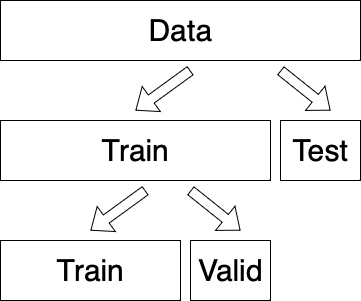

**What do we need validation**? Assume that we only have training data and testing data, and we evaluate our model with testing data. We choose the model (i.e. hyperparameter) that has the minimum testing loss. 